In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import helperFunctions

from math import ceil
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [3]:
# read the train and test csv files
og_train_df = pd.read_csv('feature_engineered_data/train.csv')
og_test_df = pd.read_csv('feature_engineered_data/test-3.csv')

In [4]:
print(f"Number of null values in og_train_df = {og_train_df.isnull().sum().sum()}")
print(f"Number of null values in og_test_df = {og_test_df.isnull().sum().sum()}")

Number of null values in og_train_df = 0
Number of null values in og_test_df = 0


In [5]:
og_train_df # showing all columns

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw,FTR
0,2009-08-07,bundesliga,Wolfsburg,Stuttgart,12,7,0,0,0,0,0,0,12,4,0,0,0,0,0,0,0,H,1.794872,0.933333,H
1,2009-08-08,bundesliga,Dortmund,FC Koln,8,11,0,0,0,0,0,0,10,0,1,0,0,0,0,0,0,H,2.314815,0.681818,H
2,2009-08-08,bundesliga,Hertha,Hannover,16,4,3,0,0,0,0,0,20,3,2,0,0,0,0,0,0,H,1.944444,0.777778,H
3,2009-08-08,bundesliga,Hoffenheim,Bayern Munich,10,1,0,0,0,0,0,1,28,3,2,0,0,0,0,1,0,A,0.809524,1.780105,D
4,2009-08-08,bundesliga,Mainz,Leverkusen,22,4,1,0,0,0,0,1,28,7,2,0,0,0,0,2,0,A,0.894737,1.700000,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2017-05-28,serie-a,Inter,Udinese,15,6,2,0,1,0,4,3,1,4,1,0,1,2,2,0,0,H,4.135338,0.647059,H
12778,2017-05-28,serie-a,Palermo,Empoli,18,5,3,0,2,1,2,0,16,4,4,0,2,0,3,0,-1,A,0.721667,2.830065,H
12779,2017-05-28,serie-a,Roma,Genoa,8,7,2,0,4,0,1,1,14,4,0,0,2,0,3,1,1,H,14.150943,0.441176,H
12780,2017-05-28,serie-a,Sampdoria,Napoli,9,2,1,0,0,3,2,0,8,7,0,0,4,1,0,2,-1,A,0.500000,6.355932,A


In [6]:
og_test_df # showing all columns

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw
0,2017-08-18,bundesliga,Bayern Munich,Leverkusen,13,8,1,0,0,0,0,2,17,4,2,0,0,0,0,0,0,H,4.800000,0.500000
1,2017-08-19,bundesliga,Hamburg,Augsburg,18,5,4,0,0,0,0,1,16,1,3,0,0,0,0,0,0,H,1.619048,0.944444
2,2017-08-19,bundesliga,Hertha,Stuttgart,18,3,2,0,0,0,0,0,12,2,1,0,0,0,0,0,0,H,1.700000,0.871795
3,2017-08-19,bundesliga,Hoffenheim,Werder Bremen,17,3,1,0,0,0,0,0,15,2,3,0,0,0,0,0,0,H,2.285714,0.923788
4,2017-08-19,bundesliga,Mainz,Hannover,18,6,3,0,0,0,0,0,14,2,5,0,0,0,0,0,0,H,1.700000,0.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,serie-a,Milan,Fiorentina,10,11,2,0,2,2,1,2,5,3,1,1,2,0,3,1,0,H,2.076503,0.904762
1822,2018-05-20,serie-a,Napoli,Crotone,3,9,0,0,3,1,1,2,9,4,0,0,2,2,1,0,0,H,3.166667,0.826087
1823,2018-05-20,serie-a,Sassuolo,Roma,14,3,1,0,4,0,1,0,8,6,1,0,4,1,0,1,1,A,0.950000,2.054054
1824,2018-05-20,serie-a,Spal,Sampdoria,10,6,1,0,2,1,2,1,11,3,4,0,2,0,3,0,0,H,2.484472,0.727273


In [7]:
og_train_df.columns

Index(['Date', 'league', 'HomeTeam', 'AwayTeam', 'HF', 'HST', 'HY', 'HR',
       'HPr5MW', 'HPr5MD', 'HPr5ML', 'HTHG', 'AF', 'AST', 'AY', 'AR', 'APr5MW',
       'APr5MD', 'APr5ML', 'HTAG', 'RstDayDiff', 'B365pred', 'B365HDstDrw',
       'B365ADstDrw', 'FTR'],
      dtype='object')

In [8]:
og_test_df.columns

Index(['Date', 'league', 'HomeTeam', 'AwayTeam', 'HF', 'HST', 'HY', 'HR',
       'HPr5MW', 'HPr5MD', 'HPr5ML', 'HTHG', 'AF', 'AST', 'AY', 'AR', 'APr5MW',
       'APr5MD', 'APr5ML', 'HTAG', 'RstDayDiff', 'B365pred', 'B365HDstDrw',
       'B365ADstDrw'],
      dtype='object')

A reminder about what each columns means  

- HF, AF = Fouls committed by HomeTeam and AwayTeam respectively  
- HY, AY = Yellow cards given by the referee to HomeTeam and AwayTeam respectively  
- HR, AR = Red cards given by the referee to HomeTeam and AwayTeam respectively  
- HST, AST = Shots on Target attempted by HomeTeam and AwayTeam respectively  
- HPr5MW, APr5MW = Number of wins in the last 5 matches for the HomeTeam and AwayTeam respectively  
- HPr5MD, APr5MD = Number of draws in the last 5 matches for the HomeTeam and AwayTeam respectively  
- HPr5ML, APr5ML = Number of losses in the last 5 matches for the HomeTeam and AwayTeam respectively  
- HTHG, HTAG = Number of goals by HomeTeam and AwayTeam at Half-time
- RstDayDiff = difference in the number of days of rest the two teams had. Positive values mean that the HomeTeam had one or more days of rest than the AwayTeam. Negative values mean AwayTeam had more days of rest. Zero means both teams had same days of rest. This feature captures the team fatigue.
- B365pred = captures what the betting crowd thinks who the winner will be.   
- B365HDstDrw, B365ADstDrw = distance from draw for HomeTeam/AwayTeam based on Bet365 betting odds.

In [9]:
og_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12782 entries, 0 to 12781
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         12782 non-null  object 
 1   league       12782 non-null  object 
 2   HomeTeam     12782 non-null  object 
 3   AwayTeam     12782 non-null  object 
 4   HF           12782 non-null  int64  
 5   HST          12782 non-null  int64  
 6   HY           12782 non-null  int64  
 7   HR           12782 non-null  int64  
 8   HPr5MW       12782 non-null  int64  
 9   HPr5MD       12782 non-null  int64  
 10  HPr5ML       12782 non-null  int64  
 11  HTHG         12782 non-null  int64  
 12  AF           12782 non-null  int64  
 13  AST          12782 non-null  int64  
 14  AY           12782 non-null  int64  
 15  AR           12782 non-null  int64  
 16  APr5MW       12782 non-null  int64  
 17  APr5MD       12782 non-null  int64  
 18  APr5ML       12782 non-null  int64  
 19  HTAG

In [10]:
og_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1826 non-null   object 
 1   league       1826 non-null   object 
 2   HomeTeam     1826 non-null   object 
 3   AwayTeam     1826 non-null   object 
 4   HF           1826 non-null   int64  
 5   HST          1826 non-null   int64  
 6   HY           1826 non-null   int64  
 7   HR           1826 non-null   int64  
 8   HPr5MW       1826 non-null   int64  
 9   HPr5MD       1826 non-null   int64  
 10  HPr5ML       1826 non-null   int64  
 11  HTHG         1826 non-null   int64  
 12  AF           1826 non-null   int64  
 13  AST          1826 non-null   int64  
 14  AY           1826 non-null   int64  
 15  AR           1826 non-null   int64  
 16  APr5MW       1826 non-null   int64  
 17  APr5MD       1826 non-null   int64  
 18  APr5ML       1826 non-null   int64  
 19  HTAG  

Let us modify our features in such a way that it will aid a tree-based model to predict the outputs better. Since tree-based models work on creating an axis-parallel seperators each time it splits the data each based on a chosen value under the chosen feature, they are not models that will actually perform arithmetic operations like a linear model will. So, we need to do this for them.  

Since it will be difficult for the model to put together HF & AF and see which team committed more fouls, we can calculate the difference between the HomeTeam and AwayTeam and make that a new feature called DF. Similarly, we can do it for columns DST, DY, DR, DPr5MW, DPr5MD, DPr5ML, HTDG. `RestDayDiff` already has this format beforehand.

Our goal here is to have positive values under features if the HomeTeam is winning/going to win and negative values if the AwayTeam is winning/going to win.  

But for features like DF (fouls committed), DY (yellow cards given by the ref), DR (red cards given by the ref) having positive values means that the HomeTeam is winning. But this is untrue. **Most of the times,** the team losing or which is going to lose tries to foul a better team often in order to prevent the better team from playing their natural game. So, we can multiply these columns with a `-1` to flip it. **Maybe the algorithm could have figured it out on its own, but I felt we help it in one more way. This will also make the interpretation of features easier for us.**

In [11]:
og_train_df['DF'] = -(og_train_df['HF'] - og_train_df['AF'])
og_test_df['DF'] = -(og_test_df['HF'] - og_test_df['AF'])

og_train_df['DST'] = og_train_df['HST'] - og_train_df['AST']
og_test_df['DST'] = og_test_df['HST'] - og_test_df['AST']

og_train_df['DY'] = -(og_train_df['HY'] - og_train_df['AY'])
og_test_df['DY'] = -(og_test_df['HY'] - og_test_df['AY'])

og_train_df['DR'] = -(og_train_df['HR'] - og_train_df['AR'])
og_test_df['DR'] = -(og_test_df['HR'] - og_test_df['AR'])

og_train_df['DPr5MW'] = og_train_df['HPr5MW'] - og_train_df['APr5MW']
og_test_df['DPr5MW'] = og_test_df['HPr5MW'] - og_test_df['APr5MW']

og_train_df['DPr5MD'] = og_train_df['HPr5MD'] - og_train_df['APr5MD']
og_test_df['DPr5MD'] = og_test_df['HPr5MD'] - og_test_df['APr5MD']

og_train_df['DPr5ML'] = og_train_df['HPr5ML'] - og_train_df['APr5ML']
og_test_df['DPr5ML'] = og_test_df['HPr5ML'] - og_test_df['APr5ML']

og_train_df['HTDG'] = og_train_df['HTHG'] - og_train_df['HTAG']
og_test_df['HTDG'] = og_test_df['HTHG'] - og_test_df['HTAG']

In [12]:
og_train_df

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw,FTR,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG
0,2009-08-07,bundesliga,Wolfsburg,Stuttgart,12,7,0,0,0,0,0,0,12,4,0,0,0,0,0,0,0,H,1.794872,0.933333,H,0,3,0,0,0,0,0,0
1,2009-08-08,bundesliga,Dortmund,FC Koln,8,11,0,0,0,0,0,0,10,0,1,0,0,0,0,0,0,H,2.314815,0.681818,H,2,11,1,0,0,0,0,0
2,2009-08-08,bundesliga,Hertha,Hannover,16,4,3,0,0,0,0,0,20,3,2,0,0,0,0,0,0,H,1.944444,0.777778,H,4,1,-1,0,0,0,0,0
3,2009-08-08,bundesliga,Hoffenheim,Bayern Munich,10,1,0,0,0,0,0,1,28,3,2,0,0,0,0,1,0,A,0.809524,1.780105,D,18,-2,2,0,0,0,0,0
4,2009-08-08,bundesliga,Mainz,Leverkusen,22,4,1,0,0,0,0,1,28,7,2,0,0,0,0,2,0,A,0.894737,1.700000,D,6,-3,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2017-05-28,serie-a,Inter,Udinese,15,6,2,0,1,0,4,3,1,4,1,0,1,2,2,0,0,H,4.135338,0.647059,H,-14,2,-1,0,0,-2,2,3
12778,2017-05-28,serie-a,Palermo,Empoli,18,5,3,0,2,1,2,0,16,4,4,0,2,0,3,0,-1,A,0.721667,2.830065,H,-2,1,1,0,0,1,-1,0
12779,2017-05-28,serie-a,Roma,Genoa,8,7,2,0,4,0,1,1,14,4,0,0,2,0,3,1,1,H,14.150943,0.441176,H,6,3,-2,0,2,0,-2,0
12780,2017-05-28,serie-a,Sampdoria,Napoli,9,2,1,0,0,3,2,0,8,7,0,0,4,1,0,2,-1,A,0.500000,6.355932,A,-1,-5,-1,0,-4,2,2,-2


In [13]:
og_test_df

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG
0,2017-08-18,bundesliga,Bayern Munich,Leverkusen,13,8,1,0,0,0,0,2,17,4,2,0,0,0,0,0,0,H,4.800000,0.500000,4,4,1,0,0,0,0,2
1,2017-08-19,bundesliga,Hamburg,Augsburg,18,5,4,0,0,0,0,1,16,1,3,0,0,0,0,0,0,H,1.619048,0.944444,-2,4,-1,0,0,0,0,1
2,2017-08-19,bundesliga,Hertha,Stuttgart,18,3,2,0,0,0,0,0,12,2,1,0,0,0,0,0,0,H,1.700000,0.871795,-6,1,-1,0,0,0,0,0
3,2017-08-19,bundesliga,Hoffenheim,Werder Bremen,17,3,1,0,0,0,0,0,15,2,3,0,0,0,0,0,0,H,2.285714,0.923788,-2,1,2,0,0,0,0,0
4,2017-08-19,bundesliga,Mainz,Hannover,18,6,3,0,0,0,0,0,14,2,5,0,0,0,0,0,0,H,1.700000,0.850000,-4,4,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,serie-a,Milan,Fiorentina,10,11,2,0,2,2,1,2,5,3,1,1,2,0,3,1,0,H,2.076503,0.904762,-5,8,-1,1,0,2,-2,1
1822,2018-05-20,serie-a,Napoli,Crotone,3,9,0,0,3,1,1,2,9,4,0,0,2,2,1,0,0,H,3.166667,0.826087,6,5,0,0,1,-1,0,2
1823,2018-05-20,serie-a,Sassuolo,Roma,14,3,1,0,4,0,1,0,8,6,1,0,4,1,0,1,1,A,0.950000,2.054054,-6,-3,0,0,0,-1,1,-1
1824,2018-05-20,serie-a,Spal,Sampdoria,10,6,1,0,2,1,2,1,11,3,4,0,2,0,3,0,0,H,2.484472,0.727273,1,3,3,0,0,1,-1,1


The `B365pred`, `B365HDstDrw`, `B365ADstDrw` columns capture the bettting odds. They can be a good indicator of which way the match will go. We can capture all three of them in one column.

In [14]:
np.unique(og_train_df['B365HDstDrw']>= 0)

array([ True])

In [15]:
np.unique(og_train_df['B365ADstDrw']>= 0)

array([ True])

In [16]:
np.unique(og_test_df['B365HDstDrw']>= 0)

array([ True])

In [17]:
np.unique(og_test_df['B365ADstDrw']>= 0)

array([ True])

As we can see, all the distance-from-drawn-match in both columns `B365HDstDrw` and `B365ADstDrw` are non-zero values. Now, comparing the distance-from-drawn-match in every row for the HomeTeam and AwayTeam, we will return a column which contains the greater value of distance-to-drawn-match. But the sign of the value will tell us which team's distance-from-drawn-match is greater. If HomeTeam's distance-from-drawn-match was greater, then it's value is returned with a positive sign. But, if distance-from-drawn-match for AwayTeam is greater, then it's a value is returned with a negative sign. 

In [18]:
? helperFunctions.maxDstDrw

Signature:  helperFunctions.maxDstDrw(row)
Docstring:
Returns max distance-from-drawn-match value based on betting odds captured by Bet365.
Positive values mean homeTeam has that much more than chances of winning instead of a draw.
Negative values means awayTeam has that much more than chances of winning instead of a draw. Negative value here does not less chances (the absolute value must be taken) but signals an awayTeam winning chances over a draw.
File:      /code/football-ftr-prediction/helperFunctions.py
Type:      function


In [19]:
og_train_df['B365DstDrw'] = og_train_df.progress_apply(helperFunctions.maxDstDrw, axis=1)
og_test_df['B365DstDrw'] = og_test_df.progress_apply(helperFunctions.maxDstDrw, axis=1)

100%|██████████| 1826/1826 [00:00<00:00, 18553.97it/s]


In [20]:
og_train_df

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw,FTR,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,B365DstDrw
0,2009-08-07,bundesliga,Wolfsburg,Stuttgart,12,7,0,0,0,0,0,0,12,4,0,0,0,0,0,0,0,H,1.794872,0.933333,H,0,3,0,0,0,0,0,0,1.794872
1,2009-08-08,bundesliga,Dortmund,FC Koln,8,11,0,0,0,0,0,0,10,0,1,0,0,0,0,0,0,H,2.314815,0.681818,H,2,11,1,0,0,0,0,0,2.314815
2,2009-08-08,bundesliga,Hertha,Hannover,16,4,3,0,0,0,0,0,20,3,2,0,0,0,0,0,0,H,1.944444,0.777778,H,4,1,-1,0,0,0,0,0,1.944444
3,2009-08-08,bundesliga,Hoffenheim,Bayern Munich,10,1,0,0,0,0,0,1,28,3,2,0,0,0,0,1,0,A,0.809524,1.780105,D,18,-2,2,0,0,0,0,0,-1.780105
4,2009-08-08,bundesliga,Mainz,Leverkusen,22,4,1,0,0,0,0,1,28,7,2,0,0,0,0,2,0,A,0.894737,1.700000,D,6,-3,1,0,0,0,0,-1,-1.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12777,2017-05-28,serie-a,Inter,Udinese,15,6,2,0,1,0,4,3,1,4,1,0,1,2,2,0,0,H,4.135338,0.647059,H,-14,2,-1,0,0,-2,2,3,4.135338
12778,2017-05-28,serie-a,Palermo,Empoli,18,5,3,0,2,1,2,0,16,4,4,0,2,0,3,0,-1,A,0.721667,2.830065,H,-2,1,1,0,0,1,-1,0,-2.830065
12779,2017-05-28,serie-a,Roma,Genoa,8,7,2,0,4,0,1,1,14,4,0,0,2,0,3,1,1,H,14.150943,0.441176,H,6,3,-2,0,2,0,-2,0,14.150943
12780,2017-05-28,serie-a,Sampdoria,Napoli,9,2,1,0,0,3,2,0,8,7,0,0,4,1,0,2,-1,A,0.500000,6.355932,A,-1,-5,-1,0,-4,2,2,-2,-6.355932


In [21]:
og_test_df

,Date,league,HomeTeam,AwayTeam,HF,HST,HY,HR,HPr5MW,HPr5MD,HPr5ML,HTHG,AF,AST,AY,AR,APr5MW,APr5MD,APr5ML,HTAG,RstDayDiff,B365pred,B365HDstDrw,B365ADstDrw,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,B365DstDrw
0,2017-08-18,bundesliga,Bayern Munich,Leverkusen,13,8,1,0,0,0,0,2,17,4,2,0,0,0,0,0,0,H,4.800000,0.500000,4,4,1,0,0,0,0,2,4.800000
1,2017-08-19,bundesliga,Hamburg,Augsburg,18,5,4,0,0,0,0,1,16,1,3,0,0,0,0,0,0,H,1.619048,0.944444,-2,4,-1,0,0,0,0,1,1.619048
2,2017-08-19,bundesliga,Hertha,Stuttgart,18,3,2,0,0,0,0,0,12,2,1,0,0,0,0,0,0,H,1.700000,0.871795,-6,1,-1,0,0,0,0,0,1.700000
3,2017-08-19,bundesliga,Hoffenheim,Werder Bremen,17,3,1,0,0,0,0,0,15,2,3,0,0,0,0,0,0,H,2.285714,0.923788,-2,1,2,0,0,0,0,0,2.285714
4,2017-08-19,bundesliga,Mainz,Hannover,18,6,3,0,0,0,0,0,14,2,5,0,0,0,0,0,0,H,1.700000,0.850000,-4,4,2,0,0,0,0,0,1.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,serie-a,Milan,Fiorentina,10,11,2,0,2,2,1,2,5,3,1,1,2,0,3,1,0,H,2.076503,0.904762,-5,8,-1,1,0,2,-2,1,2.076503
1822,2018-05-20,serie-a,Napoli,Crotone,3,9,0,0,3,1,1,2,9,4,0,0,2,2,1,0,0,H,3.166667,0.826087,6,5,0,0,1,-1,0,2,3.166667
1823,2018-05-20,serie-a,Sassuolo,Roma,14,3,1,0,4,0,1,0,8,6,1,0,4,1,0,1,1,A,0.950000,2.054054,-6,-3,0,0,0,-1,1,-1,-2.054054
1824,2018-05-20,serie-a,Spal,Sampdoria,10,6,1,0,2,1,2,1,11,3,4,0,2,0,3,0,0,H,2.484472,0.727273,1,3,3,0,0,1,-1,1,2.484472


In [22]:
# we can drop the columns we have extracted these new columns from and rearrange to appear as they did before
og_train_df.drop(columns=['Date', 'league', 'HomeTeam', 'AwayTeam', \
                          'HF', 'AF', 'HST', 'AST', 'HY', 'AY', 'HR', 'AR', \
                          'HPr5MW', 'APr5MW', 'HPr5MD', 'APr5MD', 'HPr5ML', 'APr5ML', \
                          'HTHG', 'HTAG', 'B365pred', 'B365HDstDrw', 'B365ADstDrw'], inplace=True)

og_test_df.drop(columns=['Date', 'league', 'HomeTeam', 'AwayTeam', \
                         'HF', 'AF', 'HST', 'AST', 'HY', 'AY', 'HR', 'AR', \
                         'HPr5MW', 'APr5MW', 'HPr5MD', 'APr5MD', 'HPr5ML', 'APr5ML', \
                         'HTHG', 'HTAG', 'B365pred', 'B365HDstDrw', 'B365ADstDrw'], inplace=True)

In [23]:
# rearranging columns
og_train_df = og_train_df[[
    'DF', 'DST', 'DY', 'DR', 'DPr5MW', 'DPr5MD', 'DPr5ML', 'HTDG', 
    'RstDayDiff', 'B365DstDrw', 'FTR'  ]]

og_test_df = og_test_df[[
    'DF', 'DST', 'DY', 'DR', 'DPr5MW', 'DPr5MD', 'DPr5ML', 'HTDG', 
    'RstDayDiff', 'B365DstDrw'  ]]

In [24]:
og_train_df

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw,FTR
0,0,3,0,0,0,0,0,0,0,1.794872,H
1,2,11,1,0,0,0,0,0,0,2.314815,H
2,4,1,-1,0,0,0,0,0,0,1.944444,H
3,18,-2,2,0,0,0,0,0,0,-1.780105,D
4,6,-3,1,0,0,0,0,-1,0,-1.700000,D
...,...,...,...,...,...,...,...,...,...,...,...
12777,-14,2,-1,0,0,-2,2,3,0,4.135338,H
12778,-2,1,1,0,0,1,-1,0,-1,-2.830065,H
12779,6,3,-2,0,2,0,-2,0,1,14.150943,H
12780,-1,-5,-1,0,-4,2,2,-2,-1,-6.355932,A


In [25]:
og_test_df

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw
0,4,4,1,0,0,0,0,2,0,4.800000
1,-2,4,-1,0,0,0,0,1,0,1.619048
2,-6,1,-1,0,0,0,0,0,0,1.700000
3,-2,1,2,0,0,0,0,0,0,2.285714
4,-4,4,2,0,0,0,0,0,0,1.700000
...,...,...,...,...,...,...,...,...,...,...
1821,-5,8,-1,1,0,2,-2,1,0,2.076503
1822,6,5,0,0,1,-1,0,2,0,3.166667
1823,-6,-3,0,0,0,-1,1,-1,1,-2.054054
1824,1,3,3,0,0,1,-1,1,0,2.484472


Before we change anything with the FTR column, we need to split our train_df into training and validation data. One important thing to note is that **all the changes we have made in terms of data exploration and feature engineering has respected the time component of the data i.e. for no match have we looked ahead in time and added a column to train_df and test_df. Therefore, we can treat each row indenpendently while making the prediction.**  

Let us check the distribution of the FTR column in train_df

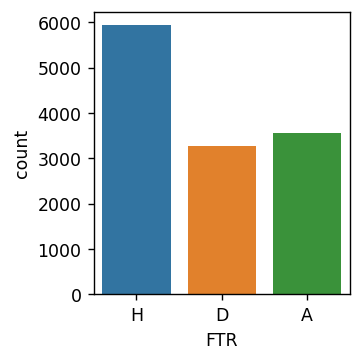

In [26]:
# dist. of the target variable in og_train_df
plt.figure(figsize=(3, 3), dpi=125)
plt.subplot(1, 1, 1)
sns.countplot(x='FTR', data = og_train_df)
plt.tight_layout()

In [27]:
np.round(np.array(list(Counter(og_train_df["FTR"]).values()))/len(og_train_df["FTR"])*100, 3)  # percentage distribution of homeWins, draws, awayWins in the og_train_df

array([46.401, 25.685, 27.914])

In [28]:
# assuming 80-20 split for train and validation, we will get roughly these many rows in the two splits

print(f"Number of rows in training split = {ceil(len(og_train_df)*0.8)}")
print(f"Number of rows in validation split = {len(og_train_df) - ceil(len(og_train_df)*0.8)}")

Number of rows in training split = 10226
Number of rows in validation split = 2556


Performing stratified k-fold cross-validation requires us to train k models to see how our robust our constructed model is. Before we get to that step, let's us build our model with a simple stratified train-validation split. To reduce the chance of a lucky/unlucky train-validation split, we will test with different randomization seeds before we proceed to the k-fold CV step. 

In [29]:
train_df, vld_df = train_test_split(og_train_df, test_size=0.2, random_state=0, stratify=og_train_df["FTR"]) # we will be setting random_state=0 everytime we break og_train_df into train_df and vld_df

In [30]:
train_df

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw,FTR
1324,3,-4,3,0,1,0,-1,-1,-1,1.571429,A
4609,-6,-2,-2,0,-4,2,2,0,0,-2.830065,A
857,1,0,-1,0,-1,-1,2,-1,-1,1.375000,A
12283,3,-1,-1,0,2,-1,-1,1,-1,2.023121,H
11088,9,2,2,0,1,-2,1,0,-5,1.347826,A
...,...,...,...,...,...,...,...,...,...,...,...
2471,1,4,2,0,-1,2,-1,1,0,2.222222,H
4306,-1,-4,-1,0,-2,-1,3,-1,-1,-3.298611,A
2590,-13,3,-4,0,-1,0,1,1,1,-1.619048,H
5586,-4,-4,2,-1,-1,-1,2,1,0,-1.178707,H


In [31]:
vld_df

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw,FTR
7587,-2,-4,1,0,0,1,-1,0,-1,1.619048,H
4927,5,3,2,0,-1,0,1,0,1,-1.111111,H
2799,-9,0,0,0,1,-1,0,-1,-1,1.700000,A
10086,1,0,-2,0,-4,3,1,0,1,-3.750000,H
8985,0,2,1,0,0,0,0,0,0,1.320000,A
...,...,...,...,...,...,...,...,...,...,...,...
7219,-10,1,0,1,1,-1,0,1,1,1.200000,A
10953,-3,0,0,0,1,1,-2,0,0,-1.444444,D
8723,4,4,0,0,4,-2,-2,0,0,6.410256,H
3799,-6,7,0,0,0,-1,1,0,-2,2.245509,H


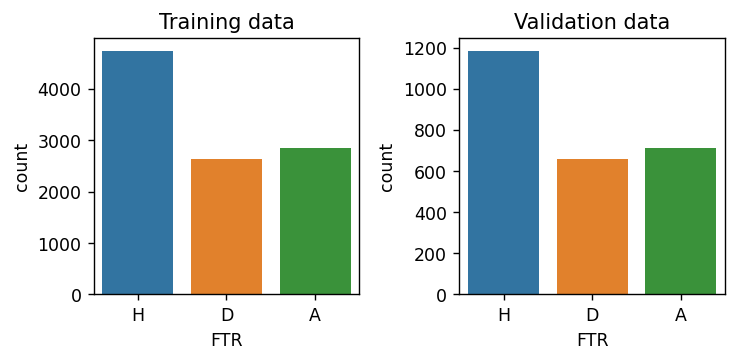

In [32]:
# dist. of the target variable
plt.figure(figsize=(6, 3), dpi=125)
plt.subplot(1, 2, 1)
sns.countplot(x='FTR', data = train_df, order=['H', 'D', 'A'])
plt.title("Training data")

plt.subplot(1, 2, 2)
sns.countplot(x='FTR', data = vld_df, order=['H', 'D', 'A'])
plt.title("Validation data")

plt.tight_layout()

In [33]:
np.round((np.array([tup[1] for tup in sorted(Counter(train_df["FTR"]).items(), reverse=True)])/len(train_df))*100, 3) # H, D, A distribution percentages in train_df

array([46.406, 25.682, 27.912])

In [34]:
np.round((np.array([tup[1] for tup in sorted(Counter(vld_df["FTR"]).items(), reverse=True)])/len(vld_df))*100, 3) # H, D, A distribution percentages in vld_df

array([46.382, 25.694, 27.923])

In [37]:
train_X, train_yTrue = train_df.iloc[:, :-1], train_df.iloc[:, -1]
vld_X, vld_yTrue = vld_df.iloc[:, :-1], vld_df.iloc[:, -1]

In [38]:
train_X

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw
1324,3,-4,3,0,1,0,-1,-1,-1,1.571429
4609,-6,-2,-2,0,-4,2,2,0,0,-2.830065
857,1,0,-1,0,-1,-1,2,-1,-1,1.375000
12283,3,-1,-1,0,2,-1,-1,1,-1,2.023121
11088,9,2,2,0,1,-2,1,0,-5,1.347826
...,...,...,...,...,...,...,...,...,...,...
2471,1,4,2,0,-1,2,-1,1,0,2.222222
4306,-1,-4,-1,0,-2,-1,3,-1,-1,-3.298611
2590,-13,3,-4,0,-1,0,1,1,1,-1.619048
5586,-4,-4,2,-1,-1,-1,2,1,0,-1.178707


In [39]:
train_yTrue

1324     A
4609     A
857      A
12283    H
11088    A
        ..
2471     H
4306     A
2590     H
5586     H
6860     A
Name: FTR, Length: 10225, dtype: object

In [40]:
param_grid = {
    'n_estimators': [75, 200, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, None], 
    'min_samples_split': [0.05, 0.1, 0.15],
    'min_samples_leaf': [0.05, 0.1, 0.15],
    'max_features': ['sqrt', 5, 8]
}

In [41]:
gridSearcher = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid=param_grid, scoring='precision_macro', verbose=1, n_jobs=-1, cv=5)

In [42]:
gridSearcher

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, None],
                         'max_features': ['sqrt', 5, 8],
                         'min_samples_leaf': [0.05, 0.1, 0.15],
                         'min_samples_split': [0.05, 0.1, 0.15],
                         'n_estimators': [75, 200, 500, 1000]},
             scoring='precision_macro', verbose=1)

In [43]:
gridSearcher.fit(train_X, train_yTrue)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 71.5min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 82.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, None],
                         'max_features': ['sqrt', 5, 8],
                         'min_samples_leaf': [0.05, 0.1, 0.15],
                         'min_samples_split': [0.05, 0.1, 0.15],
                         'n_estimators': [75, 200, 500, 1000]},
             scoring='precision_macro', verbose=1)

In [44]:
gridSearcher.best_score_ # mean cross-validated precision_macro score

0.621350994606883

In [45]:
gridSearcher.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 8,
 'min_samples_leaf': 0.05,
 'min_samples_split': 0.05,
 'n_estimators': 500}

In [46]:
gridSearcher.best_estimator_ # we will make use of this model to predict our vld_df

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features=8, min_samples_leaf=0.05,
                       min_samples_split=0.05, n_estimators=500)

In [47]:
clf = gridSearcher.best_estimator_

In [48]:
vld_yPred = clf.predict(vld_X)

In [49]:
clf.classes_

array(['A', 'D', 'H'], dtype=object)

In [52]:
vld_confMat = confusion_matrix(y_true=vld_yTrue, y_pred=vld_yPred, labels=clf.classes_)

In [53]:
vld_confMat

array([[460, 202,  52],
       [156, 369, 132],
       [ 76, 393, 717]])

In [54]:
helperFunctions.normalizeConfusionMatrix(vld_confMat) # get normalized CM

array([[0.644, 0.283, 0.073],
       [0.237, 0.562, 0.201],
       [0.064, 0.331, 0.605]])

In [55]:
helperFunctions.calculate_accuracy(vld_confMat)

'Accuracy = 60.5%'

In [60]:
print(classification_report(y_true=vld_yTrue, y_pred=vld_yPred, labels=clf.classes_))

              precision    recall  f1-score   support

           A       0.66      0.64      0.65       714
           D       0.38      0.56      0.46       657
           H       0.80      0.60      0.69      1186

    accuracy                           0.60      2557
   macro avg       0.61      0.60      0.60      2557
weighted avg       0.65      0.60      0.62      2557



**A Recall of 0.60 for H (HomeTeam wins) means that the classifier will predict that HomeTeam won 60 times out of 100 matches where the HomeTeam actually won.**

**A Precision of 0.80 means that for 80% of the matches it has predicted a win for the HomeTeam, we can trust the classifier.**  
  
Similar explanations can be made of Draw prediction and AwayTeam win predictions.

In the above report, Macro avg of Precision/Recall/F1-score gives all classes the same weight as we average the values of Precision/Recall/F1-score for the three classes. 

Weighted avg assigns weight to precision/recall/f1-score metrics based on the number of datapoints of that class (which is indicated by the support column). This means an overrepresented class like HomeTeamWin could influence the score more than the other two classes.

We can also plot the ROC-AUC and PR curves using the classifier we have trained.

In [61]:
clf.classes_

array(['A', 'D', 'H'], dtype=object)

In [62]:
vld_yTrue # we have this

7587     H
4927     H
2799     A
10086    H
8985     A
        ..
7219     A
10953    D
8723     H
3799     H
6910     A
Name: FTR, Length: 2557, dtype: object

In [66]:
vld_yTrue_scores = label_binarize(vld_yTrue, classes=clf.classes_) # we binarize the validation labels
vld_yTrue_scores

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

In [67]:
vld_yPred_scores = clf.predict_proba(vld_X)
vld_yPred_scores # this shows us the probability predictions for each by the best_estimator

array([[0.40329933, 0.44004497, 0.15665569],
       [0.19445124, 0.47534407, 0.33020469],
       [0.58756817, 0.31639887, 0.09603296],
       ...,
       [0.16986367, 0.47460193, 0.3555344 ],
       [0.16944679, 0.47428372, 0.35626949],
       [0.42630175, 0.4387907 , 0.13490754]])

Note that we optimized on `precision_macro` so that we sidestep the influence of the class imbalance as we optimize our model to find the best params. However, now we would like to just find out how the model is performing as the validation data (i.e. same distribution as the given train data). Therefore, we have shown micro-average ROC and PR curves.

{-1: 'AwayWin', 0: 'Draw', 1: 'HomeWin'}


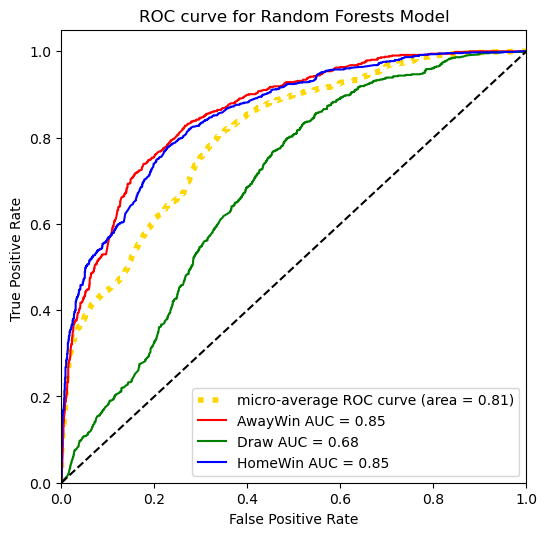

In [73]:
helperFunctions.plotROCcurve(yTrue_scores = vld_yTrue_scores, yPred_scores = vld_yPred_scores, classesInOrder = clf.classes_, classNumToName={'A':"AwayWin", 'D':"Draw", 'H':"HomeWin"}, title="ROC curve for Random Forests Model")

{-1: 'AwayWin', 0: 'Draw', 1: 'HomeWin'}
Average precision score, micro-averaged over all classes: 0.70


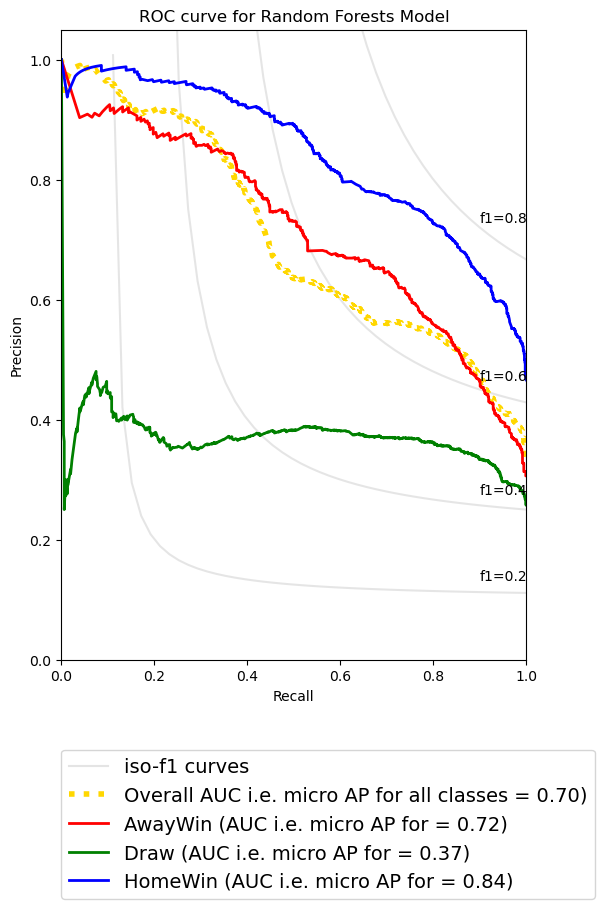

In [74]:
helperFunctions.plotPRcurve(yTrue_scores = vld_yTrue_scores, yPred_scores = vld_yPred_scores, classesInOrder = clf.classes_, classNumToName={'A':"AwayWin", 'D':"Draw", 'H':"HomeWin"}, title="ROC curve for Random Forests Model")

We can now make prediction for the `og_test_df` using the classifier we trained.

In [75]:
og_test_df

,DF,DST,DY,DR,DPr5MW,DPr5MD,DPr5ML,HTDG,RstDayDiff,B365DstDrw
0,4,4,1,0,0,0,0,2,0,4.800000
1,-2,4,-1,0,0,0,0,1,0,1.619048
2,-6,1,-1,0,0,0,0,0,0,1.700000
3,-2,1,2,0,0,0,0,0,0,2.285714
4,-4,4,2,0,0,0,0,0,0,1.700000
...,...,...,...,...,...,...,...,...,...,...
1821,-5,8,-1,1,0,2,-2,1,0,2.076503
1822,6,5,0,0,1,-1,0,2,0,3.166667
1823,-6,-3,0,0,0,-1,1,-1,1,-2.054054
1824,1,3,3,0,0,1,-1,1,0,2.484472


In [76]:
og_test_y = clf.predict(og_test_df)

In [77]:
if not os.path.exists('predictions'):
    os.mkdir('predictions')

In [80]:
with open('predictions/randomForests.txt', 'w') as fh:
    for prediction in og_test_y:
        fh.write(prediction+"\n")